In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Read in data
df_train_original = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\train.csv")
df_test_original = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\test.csv")

# Creating Duplicate Dataframe 
df_train = df_train_original.copy()
df_test = df_test_original.copy()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\luis_\\Documents\\GitHub\\data-science-projects\\house-price-prediction\\train.csv'

The objective of this project is simply to create predictive models using any library available in Python. I opted to use the [Kaggle House Prices Competition Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) since the dataset is readily available, does not require too much cleaning/wrangling, and predictions can be evaluated on the competition leaderboard.

The House Price Competition contains 2 datasets, Train and Test. The training dataset includes 1 dependent variable (SalesPrice), and 79 explanatory variables from which to predict SalesPrice. The Test dataset contains just the 79 explanatory variables. My task was to make the best predictions possible on houses in the Test dataset.

This notebook demonstrates the following approach:

- Data wrangling (Light exploration, followed by removing and transforming some variables)
- Split the training dataset into training and validation datasets
- Fit a model using a Scikit-Learn pipeline (Data Preprocessing + fitting XGBoost/LightGBM estimators with a Randomized Search across their respective hyperparameters)
- Evaluate and visualize model performance
- Implement an automated approach to selecting hyperparameters (HyperOpt)
- Make predictions

## Visualising the Dependent Variable (SalePrice)

The SalePrice variable has quite a strong positive skew, but there are still a lot of houses that sold at least 2x above the mode.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

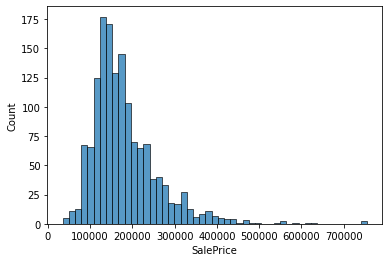

In [2]:
import seaborn as sns
sns.histplot(data=df_train, x="SalePrice")

## Data Wrangling

### Removing Id Column
The Id column simply identifies the row in the dataset and has no predictive power.

In [3]:
# Drop the ID column
df_train = df_train.drop(columns="Id")

### Checking Datatypes

The "MSSubClass" category uses integers to specify types of dwelling, but these integers simply refer to categories.
I will change the datatype of this column from int to str.

In [4]:
# Transformation 1: int > str
df_train["MSSubClass"] = df_train["MSSubClass"].astype("str")

# Apply same to df_test
df_test["MSSubClass"] = df_test["MSSubClass"].astype("str")

### Checking missing values

There are a few variables with many missing values. However, I will include these variables since I'll be using decision tree algorithms, which are robust against missing values. 
(Side note: I tried removing all variables with over 30% missing values, but the accuracy of predictions deteriorated)

In [5]:
df_train.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

### Checking Variable Skewness

#### Log Transform

In Machine Learning algorithms, the distribution of a variable can have a large effect on its usefulness in making predictions. For heavily skewed variables (as in the image below), potentially important information can be lost in lower value ranges, since higher values stretch the scale and cause lower values to be banded closely together. In this case, a log transform opens up the space between values by readjusting the scale, making it easier for an algorithm to learn how small differences in independent variables affect the dependent variable.

<img src="./log_transform.png" width="400">

Thus, it is common to log transform variables with high skewness to produce more predictive models. The following is the top 10 variables by skewness, according to the skew method in Pandas (which in turn implements [Scipy's skew](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) method with bias set to False)

In [6]:
# List variables with highest "skew"
df_train.select_dtypes(include=["int64","float64"]).skew().sort_values(ascending=False).head(10)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
dtype: float64

#### Considering the Removal/Transformation of Highly-Skewed Variables

The skewness of the "MiscVal", "LowQualFinSF", "3SsnPorch" and "PoolArea" variables is a result of the vast majority of values being 0, with a few that are not. The existence of  a non-zero value for one of these variables could end up being fairly predictive; for example, the PoolArea variable will only be non-zero for a house with a pool, and a pool is likely to add to the value of a property. Nevertheless, I removed these variables to see if predictions would improve, but they predictably become less accurate.

The distribution of the "LotArea" variable was highly skewed not because most values are zero, but more likely due to the fact that the area of a house lot follows a long-tail distribution - most houses have a small lot, but a larger mansion will have a correspondingly large lot area. This information seems predictive, so I will log transform the variable to help the machine learning algorithm make better predictions even with small differences in LotArea at the lower end of the range of values.

The visualizations below show the distribution of values for the top 5 variables by skewness. 

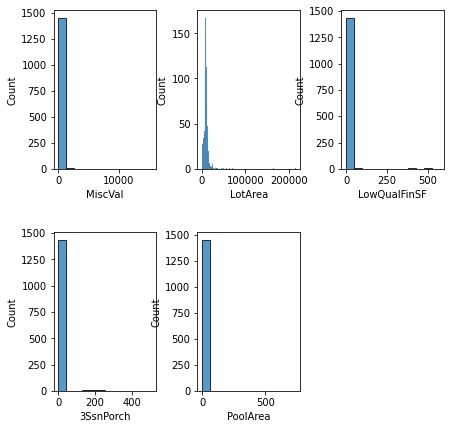

In [7]:
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 3, 1)
sns.histplot(data=df_train, x="MiscVal", ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.histplot(data=df_train, x="LotArea", ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.histplot(data=df_train, x="LowQualFinSF", ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.histplot(data=df_train, x="3SsnPorch", ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.histplot(data=df_train, x="PoolArea", ax=ax)

plt.show()

**Side note:** Since this is the first time I've log transformed skewed variables during data wrangling, and later in the process I will standardize all numerical variables to have 0 mean and unit variance with StandardScaler(), I gave some thought to ensuring the two processes don't interfere with each other.

Standard scaling is just a linear transform, and the shape of the distribution won't change as a result. A log transform changes the shape of the distribution, in this case reducing skew, and also changes the mean and variance. The resulting distributions are shown below.

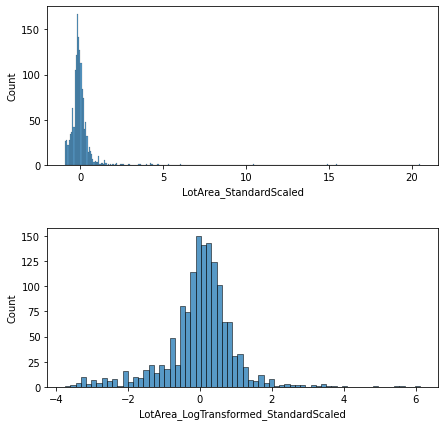

In [8]:
# Setup StandardScaler and LotArea variable
scaler = StandardScaler()
t = np.asarray(df_train['LotArea'])
t = t.reshape(-1,1)
d = {"LotArea_StandardScaled": scaler.fit_transform(t).flatten(), "LotArea_LogTransformed_StandardScaled": scaler.fit_transform(np.log(t)).flatten()}

# Create a temporary dataframe to compare distributions
df_scaling = pd.DataFrame(data=d)

# Visualize
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 1, 1)
sns.histplot(data=df_scaling, x="LotArea_StandardScaled", ax=ax)
ax = fig.add_subplot(2, 1, 2)
sns.histplot(data=df_scaling, x="LotArea_LogTransformed_StandardScaled", ax=ax)

plt.show()

Applying a log transform followed by standardization appears to be a common technique in machine learning to create more predictive models, and the visualizations above show that I am not transforming the variable in weird and unexpected ways.

In [9]:
# Log transform the LotArea variable
df_train['LotArea'] = np.log(df_train['LotArea'])
df_test['LotArea'] = np.log(df_test['LotArea'])

### Removing Variables with High Multicollinearity
Keeping sets of variables that correlate strongly with each other can contribute to overfitting, so I will discover and remove these.
Below is a correlation matrix of all numerical variables.

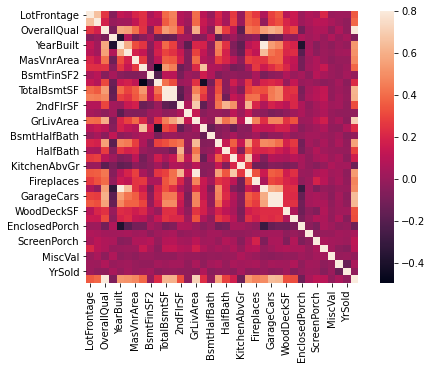

In [10]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

The list below is a summary of all variable pairs with a correlation coefficient above 0.7 or below -0.7. I will keep variables that are highly correlated with SalePrice since they will be useful in prediction. The following variables are highly correlated only with each other, so they can be removed: GarageYrBlt, TotalBsmtSF, TotRmsAbvGrd, GarageCars.

In [11]:
# Remove one variable in variable pairs where the correlation coefficient is above 0.7
threshold = 0.7
mask = corrmat.abs() > threshold
mask_2 = corrmat.abs() < 1
corrmat.where(mask & mask_2).stack()

OverallQual   SalePrice       0.790982
YearBuilt     GarageYrBlt     0.825667
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
              SalePrice       0.708624
TotRmsAbvGrd  GrLivArea       0.825489
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
SalePrice     OverallQual     0.790982
              GrLivArea       0.708624
dtype: float64

In [12]:
# Remove variables with high collinearity
df_train = df_train.drop(columns=['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'])

## Data Preprocessing
After going through a more manual process of preparing data, there are still a few steps to take across all numerical and categorical variables.

### Numerical values
- Impute missing values using the median value of the column.
- Standardize the scale of each variable by removing the mean and scaling to unit variance (variance = 1).

In [13]:
# preprocessing for numeric columns
imp_median = SimpleImputer(strategy="median", add_indicator=True)
scaler = StandardScaler()

### Categorical variables
- Impute a "missing_value" string where values are missing.
- One hot encode all categorical variables.

In [14]:
# preprocessing for categorical columns
imp_constant = SimpleImputer(strategy="constant")
ohe = OneHotEncoder(handle_unknown="ignore")

### Create pipeline and split data
Applying data transforms and then fitting a model is commonly acheived using a scikit-learn pipeline. In this case, I'll use it to separate numerical and categorical variables, apply the relevant trnsformations to each, then fit a Random Forest Regression estimator using default values for hyperparameters.

Scikit-learn also offers a method to split the training dataset into training and validation datasets, which I will implement at a ratio of 8:2.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# select columns by data type
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

# Define X (independent variables) and y (dependent variable)
X = df_train.drop(columns="SalePrice")
y = df_train["SalePrice"]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

## Setting a baseline before optimization

Before going ahead with any feature engineering or hyperparameter optimization, I'll first establish a baseline that I expect to beat.

In [16]:
#pipe.fit(X_train, y_train)
#print('Training set score: ' + str(pipe.score(X_train,y_train)))
#print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

In [17]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
49,20,RL,66.0,8.954415,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal
80,60,RL,100.0,9.472705,Pave,NaN,Reg,Lvl,AllPub,Corner,...,252,0,NaN,NaN,NaN,0,6,2009,WD,Normal
538,20,RL,NaN,9.354700,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
1058,60,RL,96.0,9.333266,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
749,50,RL,50.0,9.036582,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,20,RL,36.0,9.650078,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
351,120,RL,NaN,8.569975,Pave,NaN,IR1,Low,AllPub,Inside,...,184,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml
78,90,RL,72.0,9.285262,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
141,20,RL,78.0,9.362632,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal


In [18]:
def densify(x):
    return x.toarray()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer

densify = FunctionTransformer(densify)

preprocessing_pipe = Pipeline([('preprocessing', preprocessor), ('densify', densify)])

Keras requires the input shape to be known before attempting to fit, so the pipeline has been executed step-by-step.

In [20]:
# Define X_test
X_test = df_test.drop(columns=list(set(df_train_original.columns) - set(df_train.columns)))

In [23]:
# Data preprocessing step
X_train = preprocessing_pipe[0].fit_transform(X_train)
X_valid = preprocessing_pipe[0].transform(X_valid)
X_test =  preprocessing_pipe[0].transform(X_test)

In [24]:
# Converting from a sparse matrix to a dense array
X_train = preprocessing_pipe[1].fit_transform(X_train)
X_valid = preprocessing_pipe[1].fit_transform(X_valid)
X_test = preprocessing_pipe[1].fit_transform(X_test)

In [25]:
print(X_train.shape)
print(X_valid.shape)

(1168, 309)
(292, 309)


In [26]:
len(X_train[0])

309

In [27]:
class CreateCSV:
    
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    # For debugging
    def __str__(self):
        return f'{self.y}'
        
    def convert_to_csv(self, dataset_name):
        df = pd.DataFrame(self.x)
        if isinstance(self.y, pd.Series):
            # Align indices
            y = pd.DataFrame(self.y)
            y = y.set_index(df.index)
            # Append column to end of dataframe
            df.insert(loc=len(self.x[0]), column='y', value=y)
        else:
            pass
        
        df.to_csv("%s_preprocessed" % dataset_name, index=False)

In [28]:
training = CreateCSV(X_train, y_train)
validation = CreateCSV(X_valid, y_valid)
test = CreateCSV(X_test)

In [29]:
training.convert_to_csv("training")
validation.convert_to_csv("validation")
test.convert_to_csv("test")

In [2]:
def data():
    training = pd.read_csv("./training_preprocessed")
    validation = pd.read_csv("./validation_preprocessed")
    test = pd.read_csv("./test_preprocessed")
    X_train = training.drop(columns="y")
    y_train = training["y"]
    X_valid = validation.drop(columns="y")
    y_valid = validation["y"]
    X_test = test
    return X_train, y_train, X_valid, y_valid, X_test

In [4]:
X_train, y_train, X_valid, y_valid, X_test = data()

Potential implementations:
- Hyperopt for hyperparameters in keras layers (https://github.com/maxpumperla/hyperas)
- Hyperopt for KerasRegressor

Don't want to write out the entire model twice.

With a class, you can instantiate an object.
That object has attributes and methods.

In this case, a class works since you could pass different datasets, and the model would train in the same way.

1) Create model
2) Be able to train it on different parameters
3) Fit model on different parameters
4) Get predictions based on fit model.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import mean_absolute_error
import wandb

In [6]:
wandb.init(project="house-price-prediction", entity="luiscostigan")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(config.dropout1))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
    
    return model

In [24]:
from sklearn.model_selection import RepeatedKFold

# Instantiate the validator, have it spit out the indices, generate batches from the indices, and feed those batches to the model.
skf = RepeatedKFold(n_splits=10, n_repeats=5)
skf.get_n_splits(X_train, y_train)

50

In [37]:
from wandb.keras import WandbCallback

sweep_config = {
  "name": "keras-sequential-model-sweep",
  "method": "random",
  "parameters": {
    "dropout1": {
      "min": 0.0,
      "max": 0.8
    },
    "epochs": {
      "values": [30,50,100]
    },
    "batch_size": {
      "values": [16, 64, 128, 512]
    }
  }
}

keras_sequential_sweep_1 = wandb.sweep(sweep_config, project="house-price-prediction", entity="luiscostigan")

def train():

  with wandb.init() as run:
    config = wandb.config

    for index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
      print("Training on fold " + str(index+1) + "/10...")

      # Generate batches from indices
      xtrain, xval = X_train[train_indices], X_train[val_indices]
      ytrain, yval = y_train[train_indices], y_train[val_indices]

      model = create_model()

      model.fit(
        np.asarray(xtrain), 
        ytrain, 
        epochs=config.epochs, 
        batch_size=config.batch_size, 
        verbose=0,
        callbacks=[WandbCallback()], 
        validation_data=(np.asarray(xval),yval)
        )
      
      test_mse_score, test_mae_score = model.evaluate(np.asarray(xval), yval, callbacks=[WandbCallback()])

count = 10
wandb.agent(keras_sequential_sweep_1, function=train, count=count)

Create sweep with ID: hu1nptqm
Sweep URL: https://wandb.ai/luiscostigan/house-price-prediction/sweeps/hu1nptqm


wandb: Agent Starting Run: qeyw39li with config:
wandb: 	batch_size: 512
wandb: 	dropout1: 0.13572803881901177
wandb: 	epochs: 30


Training on fold 1/10...


wandb: ERROR Run qeyw39li errored: NameError("name 'config' is not defined")
wandb: Agent Starting Run: 4ahqfleg with config:
wandb: 	batch_size: 512
wandb: 	dropout1: 0.07986058510179062
wandb: 	epochs: 50
wandb: Ctrl + C detected. Stopping sweep.


Problem at: <ipython-input-37-ec6f380bceff> 24 train


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 951, in init
    run = wi.init()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 629, in init
    _ = backend.interface.communicate_run_start(run_obj)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/interface.py", line 221, in communicate_run_start
    result = self._communicate_run_start(run_start)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/interface_shared.py", line 423, in _communicate_run_start
    result = self._communicate(rec)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/interface_shared.py", line 213, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/router.py", line 37, in get
    is_set = self._object_ready.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line

Train the model with Hyperopt to find best parameters.
Retrain model with new best parameters.
Make predictions.

In [18]:
best_params = {
    "dropout": 0.2,
    "epochs": 100,
    "batch_size": 128
}

In [20]:
best_params = {
    "dropout": 0.2,
    "epochs": 100,
    "batch_size": 128
}

def make_predictions(best_params):
    
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(best_params.get("dropout")))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
              
    model.fit(X_train, y_train, epochs=best_params.get("epochs"),
              batch_size=best_params.get("batch_size"), verbose = 0)
    
    preds  = model.predict(X_test, best_params.get("batch_size"), verbose = 0)
              
    return preds

In [22]:
predictions = make_predictions(best_params)

## Visualize Model Output

In [26]:
d

{'Id': RangeIndex(start=0, stop=1459, step=1),
 'SalePrice': array([[136474.11],
        [156334.36],
        [188805.05],
        ...,
        [181121.44],
        [106913.19],
        [214941.02]], dtype=float32)}

In [29]:
d = {"Id":X_test.index,"SalePrice":predictions.flatten()}
submission = pd.DataFrame(data=d, index=None)

# Revert log transform
#submission["SalePrice"] = np.exp(submission["SalePrice"])

In [30]:
submission

,Id,SalePrice
0,0,136474.109375
1,1,156334.359375
2,2,188805.046875
3,3,195929.828125
4,4,200915.140625
...,...,...
1454,1454,76588.890625
1455,1455,63704.851562
1456,1456,181121.437500
1457,1457,106913.187500


In [31]:
submission.to_csv("submission.csv",index=False)